# Evaluate Hand-written Text Recognition

In [155]:
from Levenshtein import distance
import itertools
import os
import matplotlib.pyplot as plt
import re
import sys
sys.path.append(os.getcwd() + '/..')
from scripts import read_transkribus_files, printed_text

In [2]:
def print_with_color(string, color_code=1):
    print(f"\x1b[3{color_code}m{string}\x1b[m", end="")

## 1. Estimate HTR accuracy by examining printed text

In [3]:
data_dir = "../../data/Overlijden/x-samples/three-columns-100/page"
#data_dir = "../../data/Overlijden/x-samples/Training_set_V2/page"

texts, metadata, textregions = read_transkribus_files.read_files(data_dir)

In [4]:
def cleanup_text(text):
    return " ".join(text.strip().split())

In [160]:
BATCHSIZE = 1

PROMPT_DECEASED_NAME = """Here is a Dutch death certificate. 
Can you extract the name of the deceased person from this document? 
Only give the deceased name as result. 
Other information from the document is not necessary.
""" 

PROMPT_DEATH_DATE = """Here is a Dutch death certificate. 
Can you extract the death date from this document? 
Please present the result in numeric form, with a zero prepending day and month numbers smaller than 10, so for example like: 01-01-1900.
Only give the death date as result. 
Other information from the document is not necessary.
""" 

PROMPT_MOTHER_NAME = """Here is a Dutch death certificate. 
Can you extract the name of the mother of the deceased person from this document? 
Only give the mother's name as result. 
Other information from the document is not necessary.
""" 

def make_prompt_texts(texts):
    counter = 0
    for text_id in sorted(texts.keys()):
        year, district, folio_nbr = key.split("-")
        print(text_id)
        print(PROMPT_MOTHER_NAME + re.sub("\n", " ", texts[text_id]))
        counter += 1
        if counter >= BATCHSIZE:
            counter = 0
            print("\n")
            
#make_prompt_texts(texts)

In [7]:
def compare_strings(string1, text):
    clean_string = re.sub("[^a-z0-9]", "", re.sub("ç", "c", string.lower()))
    clean_text = re.sub("[^a-z0-9]", "", re.sub("ç", "c", text.lower()))
    return clean_string in clean_text

In [8]:
def get_template_id(PRINTED_TEXT, year):
    template_id = 0
    for key in PRINTED_TEXT.keys():
        if key > template_id and key <= int(year):
            template_id = key
    return template_id

In [9]:
scores = {}
for key in sorted(texts.keys()):
    year, district, folio_nbr = key.split("-")
    template_id = get_template_id(printed_text.PRINTED_TEXT, year)
    correct_text = ""
    missed_text = ""
    for string in printed_text.PRINTED_TEXT[template_id]:
        if compare_strings(string, texts[key]):
            correct_text += string
        else:
            missed_text += string
    scores[key] = len(correct_text)/len(correct_text + missed_text)
[(key[1], key[0]) for key in sorted(scores.items() ,key=lambda item: item[1])][-5:]

[(0.7371134020618557, '1866-1e-155'),
 (0.7422680412371134, '1860-1e-165'),
 (0.7422680412371134, '1860-1e-183'),
 (0.7422680412371134, '1862-1e-092'),
 (0.7422680412371134, '1867-2e-035')]

## 2. Compare names with gold data

In [10]:
import pandas as pd

In [11]:
def fix_year(text_id, date_in):
    print(text_id, date_in)
    target_year = int(text_id[:4])
    guessed_year = int(date_in[-4:])
    if guessed_year != target_year and guessed_year != target_year-1:
        print_with_color(f"changing year {guessed_year} to {target_year}!\n")
        date_out = date_in[0:-4] + str(target_year)
    else:
        date_out = date_in
    return date_out

In [12]:
GOLD_DATA = "../../data/Overlijden/x-samples/three-columns-100.csv"

In [13]:
gold_data = pd.read_csv(GOLD_DATA)

In [24]:
GOLD_DATA = "../../data/Overlijden/x-samples/three-columns-100.csv"
gold_data = pd.read_csv(GOLD_DATA)
gold_names = {}
for key in gold_data.index:
    gold_names_key = read_transkribus_files.make_file_id(gold_data["scans"][key])
    if isinstance(gold_data["first_names"][key], str):
        if isinstance(gold_data["last_name"][key], str):
            gold_name = str(gold_data["first_names"][key]) + " " + str(gold_data["last_name"][key])
        else:
            gold_name = str(gold_data["first_names"][key])
    elif isinstance(gold_data["last_name"][key], str):
        gold_name = str(gold_data["last_name"][key])
    if names_key in gold_names:
        gold_names[gold_names_key].append(gold_name)
    else:
        gold_names[gold_names_key] = [gold_name]

In [15]:
def cleanup_name(name):
    name = re.sub("[.,]", "", name)
    name = re.sub("  *", " ", name).strip()
    return name

In [44]:
def add_text_ids(names_in):
    counter = 0
    names_out = {}
    for text_id in sorted(texts.keys()):
        names_out[text_id] = names_in[counter]
        counter += 1
    return names_out

In [74]:
chatgpt_deceased_names = add_text_ids(list(pd.read_csv("deceased_names_gpt35.csv", header=None)[0]))

In [103]:
names_correct = { text_id: False for text_id in texts }
for text_id in sorted(texts.keys()):
    guessed_name = cleanup_name(chatgpt_deceased_names[text_id]).lower()
    for gold_name in gold_names[text_id]:
        gold_name = cleanup_name(gold_name).lower()
        if not names_correct[text_id]:
            names_correct[text_id] = (guessed_name == gold_name)

        
year_scores = {}
for text_id in sorted(texts.keys()):               
    year = text_id[:4]
    if year in year_scores:
        if names_correct[text_id] in year_scores[year]:
            year_scores[year][names_correct[text_id]] += 1
        else:
            year_scores[year][names_correct[text_id]] = 1
    else:
        year_scores[year] = { names_correct[text_id]: 1, not names_correct[text_id]: 0 }


names_almost_correct = {}
name_distance_counts = {}
name_distances = { text_id: 999999 for text_id in texts }
for text_id in sorted(texts.keys()):               
    for gold_name in gold_names[text_id]:
        levenshtein_distance = distance(cleanup_name(chatgpt_deceased_names[text_id]).lower(), cleanup_name(gold_name).lower())
        if levenshtein_distance < name_distances[text_id]:
            name_distances[text_id]  = levenshtein_distance
    if name_distances[text_id] not in name_distance_counts:
        name_distance_counts[name_distances[text_id]] = 1
    else:
        name_distance_counts[name_distances[text_id]] += 1
    names_almost_correct[text_id] = name_distances[text_id] <= 3
            
for text_id in sorted(texts.keys()):           
    if not names_correct[text_id]:
        try:
            print(f"{name_distances[text_id]} {chatgpt_deceased_names[text_id]} {gold_names[text_id]} {text_id}")
        except:
            pass

            
print(f"correct: {len([ True for text_id in names_correct if names_correct[text_id] ])};", 
      f"partially: {name_distance_counts[0]+name_distance_counts[1]+name_distance_counts[2]+name_distance_counts[3]};", 
      f"counts per distance: {name_distance_counts}")

2 Elisabeth Louisenne Laguna ['Elizabeth Louisienne Laguna'] 1831-1e-027
1 Mathia Albertus ['Mathias Albertus'] 1831-Oost2e-009
3 Petronella Margartha Calia ['Petronella Margaritha Calvo'] 1832-1e-068
8 Maria Dolor ['Maria Dolor Martina'] 1833-1e-046
1 Maria Antonita ['Maria Antonika'] 1833-West1e-012
6 Anna Maria Eland ['Anna Maria'] 1833-West3e-004
5 Christina Jacoba Marin ['CHRISTINA Jacoba Ronge'] 1834-1e-044
11 Jan Maria Fransa Sarfette ['Maria Theresa Parfetti'] 1834-1e-057
2 Martina Ignaais ['Martina Ignacia'] 1834-1e-179
3 Johannes Francisto ['JOHANNIS Franciska'] 1834-Oost2e-003
1 Cathalina Faneke ['CATHALINA HANEKE'] 1836-1e-114
4 Lucas Paur ['LUCAS HANSZ'] 1836-1e-169
19 Anna Theodon Decartis. ['EDERMO SILVINO DAMOEN'] 1837-1e-204
8 Partha Sophia Koober ['Janetta Sophia KOOLMEIER'] 1839-1e-104
5 Joseph Bleuw ['JOSEPH BLEISWIJK'] 1840-1e-115
4 Belfaars Calafet ['BELFACIO CALAFIT'] 1841-1e-083
2 Maria Felies ['MARIA FELICI'] 1841-1e-111
7 Leidewich Christint Boe. ['LUDEWICH CH

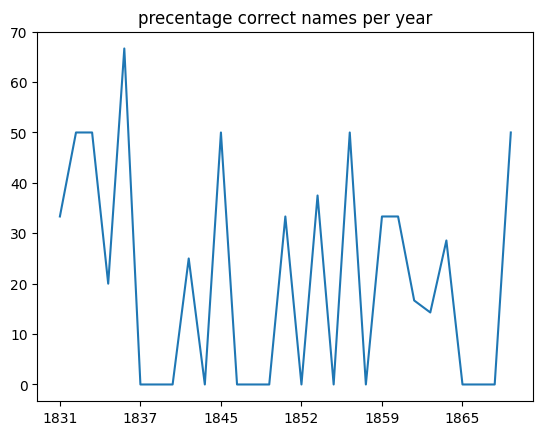

In [72]:
plt.plot(year_scores.keys(), [ 100*year_scores[year][True]/(year_scores[year][True] + year_scores[year][False]) for year in year_scores ])
plt.xticks(range(0, 30, 5))
plt.title("precentage correct names per year")
plt.show()

## 3. Compare guessed names to known names

In [76]:
known_certificates = pd.read_csv("../../data/Overlijden/x-misc/Overlijden 1831-1950 JESSYv2-1831-1929.csv", low_memory=False)

In [120]:
name_types = {}
name_counts = {}
MINIMUM_YEAR = 1869

for index, row in known_certificates.iterrows():
    surname = row["Achternaam"]
    firstnames = row["Voornamen"]
    try:
        year = int(row["Jaar"])
    except:
        continue
    if isinstance(surname, str) and year >= MINIMUM_YEAR:
        for name_part in surname.strip().split():
            clean_name = cleanup_name(name_part).lower()
            if clean_name not in name_types:
                name_types[clean_name] = "last"
            if clean_name in name_counts:
                name_counts[clean_name] += 1
            else:
                name_counts[clean_name] = 1
    if isinstance(firstnames, str) and year >= MINIMUM_YEAR:
        for name_part in firstnames.strip().split():
            clean_name = cleanup_name(name_part).lower()
            if clean_name not in name_types:
                name_types[clean_name] = "first"
            elif name_types[clean_name] == "last":
                name_types[clean_name] = "both"
            if clean_name in name_counts:
                name_counts[clean_name] += 1
            else:
                name_counts[clean_name] = 1

In [147]:
MINIMUM_FREQUENCY = 10

def get_closest_name(name):
    if name in name_types.keys():
        return [name], 0
    min_distance = 999999
    best_names = []
    for known_name in name_types:
        if name_counts[known_name] >= MINIMUM_FREQUENCY:
            this_distance = distance(cleanup_name(known_name), name)
            if this_distance < min_distance:
                min_distance = this_distance
                best_names = [known_name]
            elif this_distance == min_distance:
                best_names.append(known_name)
    return best_names, min_distance

In [130]:
has_unknown_name = { text_id: False for text_id in texts }
for text_id in chatgpt_deceased_names:
    name_format = []
    for name_part in chatgpt_deceased_names[text_id].strip().split():
        clean_name = cleanup_name(name_part).lower()
        if clean_name in name_types:
            name_format.append(name_types[clean_name])
        else:
            print(f"unknown name: {clean_name}, {get_closest_name(clean_name)}")
            name_format.append("UNKNOWN")
            has_unknown_name[text_id] = True
    print(name_format)

unknown name: louisenne, (['louise'], 3)
['first', 'UNKNOWN', 'last']
['both']
unknown name: mathia, (['mathias', 'mathea', 'mathida'], 1)
['UNKNOWN', 'first']
unknown name: margartha, (['margaritha', 'margaretha'], 1)
unknown name: calia, (['casia', 'ocalia', 'dalia', 'celia', 'cilia'], 1)
['first', 'UNKNOWN', 'UNKNOWN']
['first', 'first']
unknown name: dolor, (['dolores', 'doloris', 'noor', 'polon', 'doloria', 'odor'], 2)
['both', 'UNKNOWN']
['first', 'first']
['both', 'first']
unknown name: eland, (['eiland'], 1)
['first', 'both', 'UNKNOWN']
['first', 'first']
['first', 'first', 'first']
unknown name: fransa, (['frans', 'franca', 'franka'], 1)
unknown name: sarfette, (['mariette', 'rafette'], 2)
['first', 'both', 'UNKNOWN', 'UNKNOWN']
unknown name: ignaais, (['ignacia', 'ignatio', 'ignacio', 'ignatia', 'ignasio', 'ignasia', 'ignaria', 'ignatius', 'ignacius'], 2)
['both', 'UNKNOWN']
unknown name: francisto, (['francisco', 'francisko'], 1)
['first', 'UNKNOWN']
unknown name: faneke, ([

In the ChatGPT3.5 output there are 64 names with unknown parts (not found in the 1869+ data). Of these names 61 (95%) are wrong while 3 (5%) are correct. This analysis is different for the partially correct names: 34 of the 64 names have a Levenshtein distance of 3 or smaller to the correct name while for the other 30 the distance is larger.

In [131]:
correct_count = 0
wrong_count = 0
almost_correct_count = 0
not_almost_correct_count = 0
for text_id in has_unknown_name:
    if has_unknown_name[text_id]:
        if names_correct[text_id]:
            correct_count += 1
        else:
            wrong_count += 1
        if names_almost_correct[text_id]:
            almost_correct_count += 1
        else:
            not_almost_correct_count += 1
print(f"correct: {correct_count}; wrong: {wrong_count}; almost correct: {almost_correct_count}; not almost correct: {not_almost_correct_count}")

correct: 3; wrong: 61; almost correct: 34; not almost correct: 30


Replacing unknown names with known names does not have a big effect. Only a few names can be corrected because most names have many alternatives. This makes choosing the correct alternative difficult.

In [126]:
def find_most_frequent(name_types, name_alternatives):
    best_name = name_alternatives[0]
    highest_frequency = name_types[best_name]
    for name_alternative in name_alternatives:
        if (name_types[name_alternative] > highest_frequency or 
            (name_types[name_alternative] == highest_frequency and len(name_alternative) > len(best_name))):
            best_name = name_alternative
            highest_frequency = name_types[best_name]
    return best_name

In [150]:
for text_id in sorted(texts.keys()):
    name_correct = False
    guessed_name = cleanup_name(chatgpt_deceased_names[text_id]).lower()
    for gold_name in gold_names[text_id]:
        gold_name = cleanup_name(gold_name).lower()
        if not name_correct:
            name_correct = (guessed_name == gold_name)
    if not name_correct:
        name_parts_corrected = []
        corrected = True
        for name_part in guessed_name.split():
            if name_part in name_types:
                name_parts_corrected.append(name_part)
            else:
                name_alternatives, name_distance = get_closest_name(name_part)
                if name_distance > 3:
                    name_parts_corrected.append(name_part)
                    corrected = False
                elif len(name_alternatives) == 1:
                    name_parts_corrected.append(name_alternatives[0])
                else:
                    if len(name_alternatives) == 0:
                        print_with_color("cannot happen")
                    name_parts_corrected.append(find_most_frequent(name_types, name_alternatives))
        name_corrected = " ".join(name_parts_corrected)
        if name_corrected != guessed_name and corrected:
            corrected_distance = distance(name_corrected, cleanup_name(gold_names[text_id][0]).lower())
            if corrected_distance > 0:
                print(f"{corrected_distance} {distance(guessed_name, cleanup_name(gold_names[text_id][0]).lower())} {name_corrected} # {guessed_name} {gold_names[text_id]}")
            else:
                print_with_color(f"{corrected_distance} {distance(guessed_name, cleanup_name(gold_names[text_id][0]).lower())} {name_corrected} # {guessed_name} {gold_names[text_id]}\n")

5 2 elisabeth louise laguna # elisabeth louisenne laguna ['Elizabeth Louisienne Laguna']
0 1 mathias albertus # mathia albertus ['Mathias Albertus']
4 3 petronella margaritha atalia # petronella margartha calia ['Petronella Margaritha Calvo']
8 8 maria dolores # maria dolor ['Maria Dolor Martina']
6 6 anna maria elena # anna maria eland ['Anna Maria']
13 11 jan maria frans mariette # jan maria fransa sarfette ['Maria Theresa Parfetti']
3 2 martina ignatius # martina ignaais ['Martina Ignacia']
3 3 johannes francisco # johannes francisto ['JOHANNIS Franciska']
3 1 cathalina faneyte # cathalina faneke ['CATHALINA HANEKE']
4 4 lucas paul # lucas paur ['LUCAS HANSZ']
18 19 anna theodor martis # anna theodon decartis ['EDERMO SILVINO DAMOEN']
8 8 martha sophia hooier # partha sophia koober ['Janetta Sophia KOOLMEIER']
6 5 joseph leeuw # joseph bleuw ['JOSEPH BLEISWIJK']
0 3 maria merselina # maria mersele ['MARIA MERSELINA']
7 7 elisabeth petrus # elisabeth petstus ['ELISABETH WINDT, de']
0

## 4. Free word order evaluation

In [188]:
names_correct_unordered = { text_id: False for text_id in texts }
for text_id in sorted(texts.keys()):
    guessed_name = cleanup_name(chatgpt_deceased_names[text_id]).lower()
    for gold_name in gold_names[text_id]:
        gold_name = cleanup_name(gold_name).lower()
        for permutation in itertools.permutations(guessed_name.split()):
            if not names_correct_unordered[text_id]:
                names_correct_unordered[text_id] = (" ".join(permutation) == gold_name)
                if " ".join(permutation) != guessed_name and " ".join(permutation) == gold_name:
                    print(permutation, guessed_name)

('apolonia', 'maria') maria apolonia


In [183]:
len([ True for text_id in names_correct if names_correct_unordered[text_id] ])

23

## 5. Evaluate with name of mother

In [179]:
mother_names = pd.read_csv("mothers.csv", header=None).to_dict(orient="records")
mother_names = { item[0]: item[1] for item in mother_names }

In [190]:
names_correct_with_mother = { text_id: False for text_id in texts }
for text_id in sorted(texts.keys()):
    guessed_name = cleanup_name(chatgpt_deceased_names[text_id]).lower()
    for gold_name in gold_names[text_id]:
        gold_name = cleanup_name(gold_name).lower()
        if not names_correct_with_mother[text_id]:
            names_correct_with_mother[text_id] = (guessed_name == gold_name)
    if isinstance(mother_names[text_id], str) and not names_correct_with_mother[text_id]:
        mother_name = cleanup_name(mother_names[text_id]).lower().split()[-1]
        for gold_name in gold_names[text_id]:
            gold_name = cleanup_name(gold_name).lower()
            if not names_correct_with_mother[text_id]:
                names_correct_with_mother[text_id] = (guessed_name + " " + mother_name == gold_name)
                if guessed_name + " " + mother_name == gold_name:
                    print(guessed_name, mother_name, gold_name, sep="#")

anna wilhelmina#boom#anna wilhelmina boom


In [191]:
len([ True for text_id in names_correct if names_correct_with_mother[text_id] ])

23